# Importando bibliotecas e dataset 

In [1]:
# Adicionando ao path para facilitar importações de arquivos
import sys
sys.path.append('../')

In [2]:
# Descomente a linha abaixo na primeira execução, caso não possua o `pt_core_news_lg`
# !python -m spacy download pt_core_news_lg

In [3]:
import re
import string
import pandas as pd
import numpy as np
import spacy
import nltk
import pt_core_news_lg
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.sentiment import SentimentIntensityAnalyzer
from LeIA import SentimentIntensityAnalyzer as LeIASentimentIntensityAnalyzer
from tqdm import tqdm


pd.options.display.max_colwidth = 100

In [4]:
file_path = '../data/raw/ErikakHilton-tweets.csv'
df = pd.read_csv(file_path, on_bad_lines='skip', sep=';', encoding='utf-8')

/tmp/ipykernel_14749/3505034139.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, on_bad_lines='skip', sep=';', encoding='utf-8')


In [5]:
df.shape

(22505, 49)

# Pré processamento

## Filtrar tweets
Vamos remover tweets repetidos e filtrar uma amostra menor, para facilitar a comparação manual de resultados

In [6]:
duplicated_indexes = df[df.duplicated()].index
sample_df = df.drop(duplicated_indexes)
sample_df.shape

(20505, 49)

In [7]:
sample_df = sample_df[:100]

## Limpeza dos tweets

In [8]:
# Removendo "não" das stopwords
STOP_WORDS.remove('não')

# Instanciando spacy/pt_core_news_lg - corpus completo
nlp = spacy.load('pt_core_news_lg')

In [9]:
# Função para remover URL
def remover_url(texto):
    texto = re.sub(r'http\S+', '', texto)
    return texto

# Função para remover contas
def remover_twiters(texto):
    texto = re.sub(r'@\w+', '', texto)
    return texto

# Função para remover pontuações
def remover_pontuacao(texto):
    texto = re.sub(f"[{re.escape(string.punctuation)}]", "", texto)
    return texto

# Função para remoção de stopwords e digitos
def limpar_texto(texto):
    doc = nlp(texto)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_digit]
    texto_limpo = " ".join(tokens)
    return texto_limpo

In [10]:
# Aplicando limpezas
tweets = sample_df['rawContent']

tweets = tweets.str.lower()
tweets = tweets.apply(remover_url)
tweets = tweets.apply(remover_twiters)
tweets = tweets.apply(remover_pontuacao)
tweets = tweets.apply(limpar_texto)

In [11]:
# Jogando de volta para o dataframe
sample_df['content_formatted'] = tweets

In [12]:
sample_df[['rawContent', 'content_formatted']].head()

,rawContent,content_formatted
0,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",longo dia recebendo denúncias pessoas presas há 16h estrada água comida bloqueios ilegais caminh...
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,simplesmente ❤ ️ ❤ ️ ❤ ️
2,@PalasAthenas18 Hahahhaha 💜💜💜,hahahhaha 💜 💜 💜
4,@ErikakHilton É isso aí...,
5,@Mendes2588 🫶🏾🫶🏾,🫶🏾🫶🏾


## Lemmatizando

In [13]:
# Função para lemmatização
def lemmatiza(texto):
    doc = nlp(texto)
    lemmatized_tokens = []
    for token in doc:
        lemmatized_tokens.append(token.lemma_)
    return " ".join(lemmatized_tokens)

In [14]:
sample_df['lemma_content'] = sample_df['content_formatted'].apply(lemmatiza)

# Análise de Sentimento

## Vader Sentiment Intensity Analysis
O Vader (do NLTK) não foi treinado com português, portanto seus resultados não são confiáveis. Vamos aplicar aqui apenas para comparar com o LeIA

In [15]:
nltk.download('vader_lexicon') # download do sentiment lexicon

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/paim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
vader_sia = SentimentIntensityAnalyzer()

def vader_sentiment_analysis(text):
    return vader_sia.polarity_scores(text)['compound']

sample_df['vader_sentiment_score'] = sample_df['lemma_content'].apply(vader_sentiment_analysis)

<Axes: >

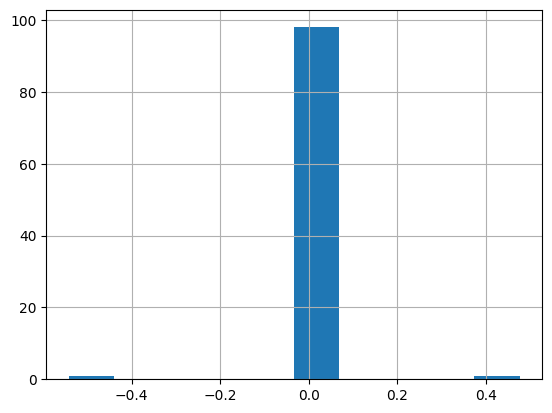

In [17]:
sample_df['vader_sentiment_score'].hist()

## LeIA Sentiment Intensity Analysis

LeIA (Léxico para Inferência Adaptada) é uma adaptação da analise de intensidade de sentimento do Vader para o português

In [18]:
leia_sia = LeIASentimentIntensityAnalyzer() # criar sentiment analyzer

def leia_sentiment_analysis(text):
    return leia_sia.polarity_scores(text)['compound']

sample_df['leia_sentiment_score'] = sample_df['lemma_content'].apply(leia_sentiment_analysis)

<Axes: >

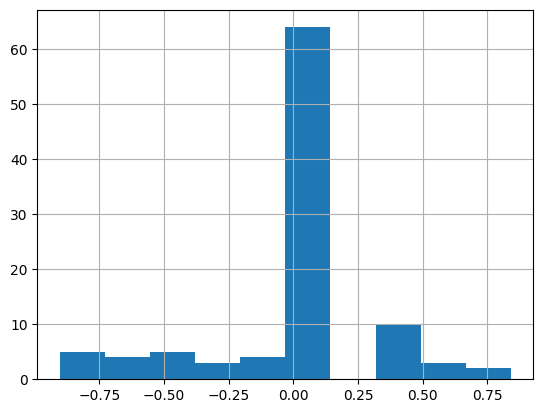

In [19]:
sample_df['leia_sentiment_score'].hist()

## Avaliação do ChatGPT
Vamos usar a API do ChatGPT para gerar outra análise de sentimentos, para comparar os resultados.

In [23]:
import os
import openai
from src.config import OPENAI_API_KEY

openai.api_key = OPENAI_API_KEY

In [21]:
"""
Estava tentando um resultado mais elaborado, mas as respostas estão muito inconsistentes. 
Acho que vale a pena tentar otimizar os prompts para respostas mais precisas e bem explicadas
"""
# base_msg = (
#     "Você é meu assistente de PLN e fará uma análise de sentimentos nos tweets que eu mandar. "
#     "Os tweets serão enviados no formato CSV com duas colunas (separadas por ;;):\n - Id do tweet\n - Texto do tweet\n\n"
#     "Para cada tweet você deve gerar um score de -1 (extremamente negativo) a 1(extremamente positivo), com até 4 casas decimais.\n"
#     "Sua resposta deve vir no formato de um arquivo CSV com três colunas (separadas por ;;):\n"
#     " - Id do tweet\n - Score de sentimentos do tweet\n - Breve explicação do score\n\n"
#     "Aqui vão os tweets para análise:\n"
# )

# def get_chatgpt_tweet_input(tweet):
#     return f"{tweet.id};;{tweet.rawContent}"

# tweets_input = sample_df[:10].apply(get_chatgpt_row_input, axis=1).values
# tweets_input = '\n'.join(tweets_input)

# msg = base_msg + tweets_input
# print(msg)
# print('\n\n')

# completion = openai.ChatCompletion.create(
#     model="gpt-3.5-turbo",
#     messages=[{"role": "user", "content": msg}],
#     temperature=0,
# )

# print(completion.choices[0].message.content)

'\nEstava tentando um resultado mais elaborado, mas as respostas estão muito inconsistentes. \nAcho que vale a pena tentar otimizar os prompts para respostas mais precisas e bem explicadas\n'

In [24]:
base_msg = (
    "Você é meu assistente de PLN e irá realizar uma análise de sentimentos no tweet que eu enviar. "
    "Você deve gerar um score de sentimento de -1 (extremamente negativo) a 1(extremamente positivo), com até 4 casas decimais. "
    "Sua resposta deve conter apenas o número do score de sentimento."
    "Tweet: "
)

raw_chatgpt_sentiment_score = []

for tweet in sample_df['rawContent']:
    msg = base_msg + tweet    
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": msg}],
        temperature=0,
    )

    raw_chatgpt_sentiment_score.append(completion.choices[0].message.content)

In [25]:
print(raw_chatgpt_sentiment_score)

['-0.8750', '0.8750', '0.8', '0.0', '0.0', '0.8', '0.0', '0.4583', '0.0', '-0.7847', '-0.8571', '0.0', '0.7788', '0.7143', '0.0', '0.9', '0.8750', '-0.5714', '-0.9365', '0.8750', '0.8750', '-0.5', '0.8750', '1.0', '-0.8571', '0.6364', '0.4583', '-0.7847', 'Desculpe, mas não é possível realizar a análise de sentimentos sem o conteúdo do tweet. Por favor, envie o tweet completo para que eu possa gerar o score de sentimento.', '-0.7143', '-0.9365', '-0.8571', '0.8750', '0.8750', '0.4583', '0.9375', '0.4583', '-0.5', '-0.8571', '0.8750', '0.9365', '-0.5714', '0.4583', '0.8750', '0.8750', '0.7782', '0.9583', '0.9712', '-0.8571', '-0.9', '0.2', '-0.9365', 'Desculpe, mas como assistente de PLN, não tenho acesso ao conteúdo do tweet fornecido. Por favor, forneça o texto do tweet para que eu possa realizar a análise de sentimentos.', '1.0', '0.0', '1.0', '0.5', '0.8', '-0.8', '0.75', '0.0', '0.8750', '0.4583', '0.4583', '0.9717', '0.9750', '0.4583', '1.0', '-0.8571', '0.5719', '-0.8571', '-0.45

In [26]:
# O ChatGPT não conseguiu avaliar alguns tweets, por isso precisamos remover alguns dos resultados
def convert_score(raw_score):
    try:
        return float(score)
    except Exception as e:
        return None

chatgpt_sentiment_score = []
for score in raw_chatgpt_sentiment_score:
    chatgpt_sentiment_score.append(convert_score(score))
    
sample_df['chatgpt_sentiment_score'] = chatgpt_sentiment_score

# Comparação de Resultados

Axes(0.125,0.11;0.775x0.77)


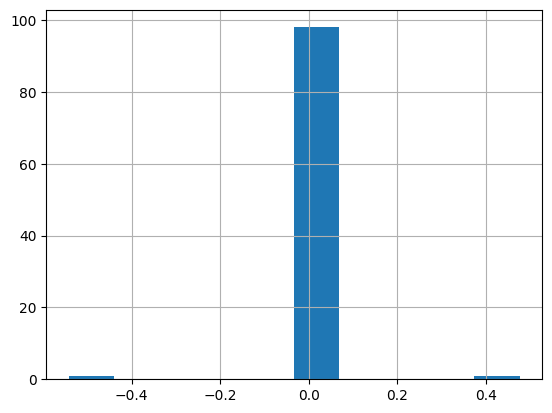

In [27]:
print(sample_df['vader_sentiment_score'].hist())

Axes(0.125,0.11;0.775x0.77)


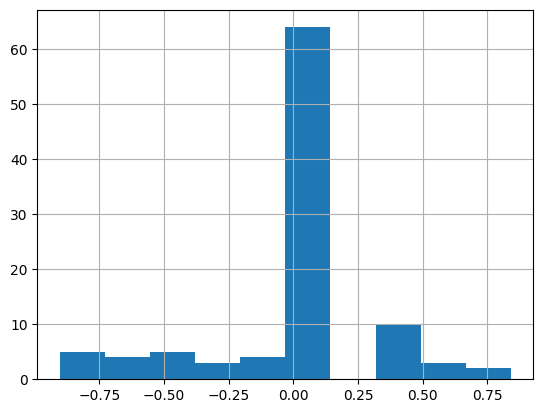

In [28]:
print(sample_df['leia_sentiment_score'].hist())

Axes(0.125,0.11;0.775x0.77)


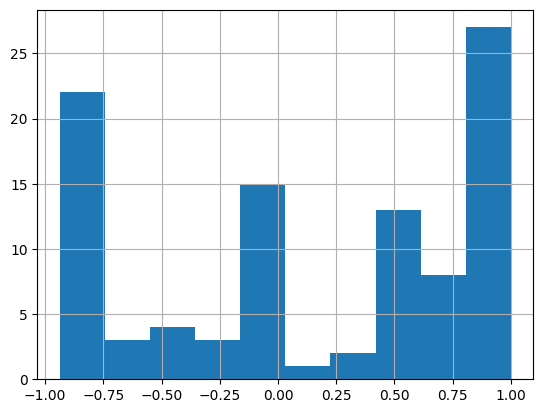

In [29]:
print(sample_df['chatgpt_sentiment_score'].hist())

Axes(0.125,0.11;0.775x0.77)


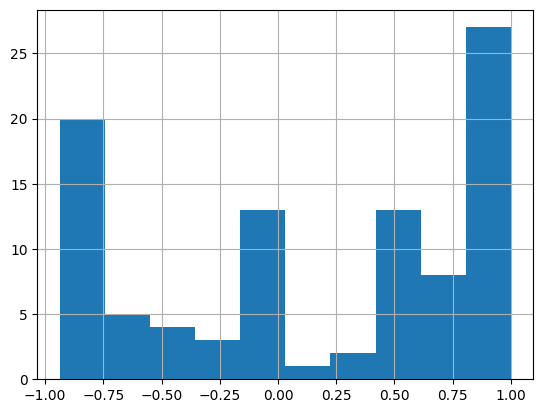

In [281]:
print(sample_df['chatgpt_sentiment_score'].hist())

In [282]:
sample_df[['rawContent', 'lemma_content', 'vader_sentiment_score', 'leia_sentiment_score', 'chatgpt_sentiment_score']]

,rawContent,lemma_content,vader_sentiment_score,leia_sentiment_score,chatgpt_sentiment_score
0,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",longo dia receber denúncia pessoa presas haver 16h estrada água comer bloqueio ilegal caminhonei...,0.0,-0.7579,-0.8750
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,simplesmente ❤ ️ ❤ ️ ❤ ️,0.0,0.0000,0.8750
2,@PalasAthenas18 Hahahhaha 💜💜💜,hahahhaha 💜 💜 💜,0.0,0.0000,0.8000
4,@ErikakHilton É isso aí...,,0.0,0.0000,0.0000
5,@Mendes2588 🫶🏾🫶🏾,🫶🏾🫶🏾,0.0,0.0000,0.0000
...,...,...,...,...,...
103,@ErikakHilton @LulaOficial ouvimos amém,ouvir amém,0.0,0.0000,0.0000
104,@ErikakHilton @LulaOficial Isso já tá sendo tudo pra minha saúde mental. O silêncio.,tar ser pra saúde mental silêncio,0.0,0.0000,0.3182
105,Cada hora de silêncio que passa só mostra o quão pequeno é um sujeito como Bolsonaro.\n\nQue sai...,hora silêncio passar mostrar quão pequeno sujeitar bolsonaro \n\n saia presidência pra voltar,0.0,0.0000,-0.8571
106,@ErikakHilton obrigada por tudo 💜,💜,0.0,0.0000,0.8750


In [284]:
# Necessário remover as linhas com None para calcular o erro
results_df = sample_df.dropna(subset=['leia_sentiment_score', 'chatgpt_sentiment_score'])

# Calculando métricas da análise
mae = mean_absolute_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)
mse = mean_squared_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)

print(f"MAE: {mae}")
print(f"MSE: {mse}")

MAE: 0.5231135416666667
MSE: 0.40081571052083337


## Salvando os resultados

In [30]:
sample_df[:10]

,url,date,rawContent,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,user_protected,user_link,user_profileImageUrl,user_profileBannerUrl,user_label,content_formatted,lemma_content,vader_sentiment_score,leia_sentiment_score,chatgpt_sentiment_score
0,https://twitter.com/ErikakHilton/status/1587217512470659074,2022-10-31 22:58:38+00:00,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...","Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",1587217512470659074,https://twitter.com/ErikakHilton,61,327,2568,63,...,False,"TextLink(text='erikahilton.com.br', url='http://erikahilton.com.br/', tcourl='https://t.co/5KKZ3...",https://pbs.twimg.com/profile_images/1559380990333706240/vEImKRHW_normal.jpg,https://pbs.twimg.com/profile_banners/738143559920934912/1670375803,NaN,longo dia recebendo denúncias pessoas presas há 16h estrada água comida bloqueios ilegais caminh...,longo dia receber denúncia pessoa presas haver 16h estrada água comer bloqueio ilegal caminhonei...,0.0000,-0.7579,-0.8750
1,https://twitter.com/PalasAthenas18/status/1587217834643423232,2022-10-31 22:59:55+00:00,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,1587217834643423232,https://twitter.com/PalasAthenas18,3,2,204,0,...,False,NaN,https://pbs.twimg.com/profile_images/1622763976307212291/G_dY8w3Z_normal.jpg,https://pbs.twimg.com/profile_banners/1240253653451227136/1665902903,NaN,simplesmente ❤ ️ ❤ ️ ❤ ️,simplesmente ❤ ️ ❤ ️ ❤ ️,0.0000,0.0000,0.8750
2,https://twitter.com/ErikakHilton/status/1587217915220213762,2022-10-31 23:00:14+00:00,@PalasAthenas18 Hahahhaha 💜💜💜,@PalasAthenas18 Hahahhaha 💜💜💜,1587217915220213762,https://twitter.com/ErikakHilton,0,0,19,0,...,False,"TextLink(text='erikahilton.com.br', url='http://erikahilton.com.br/', tcourl='https://t.co/5KKZ3...",https://pbs.twimg.com/profile_images/1559380990333706240/vEImKRHW_normal.jpg,https://pbs.twimg.com/profile_banners/738143559920934912/1670375803,NaN,hahahhaha 💜 💜 💜,hahahhaha 💜 💜 💜,0.0000,0.0000,0.8000
4,https://twitter.com/LNaty125/status/1587217794789265409,2022-10-31 22:59:46+00:00,@ErikakHilton É isso aí...,@ErikakHilton É isso aí...,1587217794789265409,https://twitter.com/LNaty125,1,0,1,0,...,False,NaN,https://pbs.twimg.com/profile_images/1563859369514733569/-WoAV1XK_normal.jpg,https://pbs.twimg.com/profile_banners/1186596179087376386/1672607870,NaN,,,0.0000,0.0000,0.0000
5,https://twitter.com/ErikakHilton/status/1587217852381143042,2022-10-31 22:59:59+00:00,@Mendes2588 🫶🏾🫶🏾,@Mendes2588 🫶🏾🫶🏾,1587217852381143042,https://twitter.com/ErikakHilton,1,0,2,0,...,False,"TextLink(text='erikahilton.com.br', url='http://erikahilton.com.br/', tcourl='https://t.co/5KKZ3...",https://pbs.twimg.com/profile_images/1559380990333706240/vEImKRHW_normal.jpg,https://pbs.twimg.com/profile_banners/738143559920934912/1670375803,NaN,🫶🏾🫶🏾,🫶🏾🫶🏾,0.0000,0.0000,0.0000
6,https://twitter.com/LNaty125/status/1587217956999761923,2022-10-31 23:00:24+00:00,@ErikakHilton 🤏🏻❤,@ErikakHilton 🤏🏻❤,1587217956999761923,https://twitter.com/LNaty125,0,0,0,0,...,False,NaN,https://pbs.twimg.com/profile_images/1563859369514733569/-WoAV1XK_normal.jpg,https://pbs.twimg.com/profile_banners/1186596179087376386/1672607870,NaN,🤏🏻 ❤,🤏🏻 ❤,0.0000,0.0000,0.8000
8,https://twitter.com/ErikakHilton/status/1587217807422414855,2022-10-31 22:59:49+00:00,@juknobel 🫶🏾,@juknobel 🫶🏾,1587217807422414855,https://twitter.com/ErikakHilton,0,0,11,0,...,False,"TextLink(text='erikahilton.com.br', url='http://erikahilton.com.br/', tcourl='https://t.co/5KKZ3...",https://pbs.twimg.com/profile_images/1559380990333706240/vEImKRHW_normal.jpg,https://pbs.twimg.com/profile_banners/738143559920934912/1670375803,NaN,🫶🏾,🫶🏾,0.0000,0.0000,0.0000
15,https://twitter.com/hikarumasaof/status/1587218045684142084,2022-10-31 23:00:45+00:00,"@ErikakHilton Ah obrigado, Erika, já tava aflito sem sa

In [285]:
output_path = '../data/processed/'
output_file = f'sentiment_analysis_comparison_output.csv'

# Para salvar os dados, descomente as linhas abaixo
# sample_df.to_csv(f"{output_path}{output_file}", sep=';', encoding='utf-8', index=False)